In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

In [2]:
class KMeans:
    def __init__(self, k, method='random', max_iter=300):
        self.k = k 
        self.method = method
        self.max_iter = max_iter

    def init_centers(self, X: np.ndarray):
        if self.method == 'random':
            # return X[np.random.randint(X.shape[0], size=self.k, replace=False)]
            return X[np.random.choice(X.shape[0], size=self.k, replace=False)]
        if self.method == 'k-means++':
            centroids = []
            Xs = []
            probs = []
            ind = np.random.choice(X.shape[0], 1)
            centroids.append(X[ind])
            Xs.append(np.concatenate([X[:ind], X[ind+1:]], axis=None))
            dist = self.calculate_distances(Xs[0], np.array([X[ind]]))
            dist_square = np.square(dist)
            probs.append(dist_square / dist_square.sum())
            for i in range(1, self.k):
                ind = np.random.choice(Xs[i-1].shape[0], 1, p=probs[i-1])
                centroids.append(Xs[i-1][ind])

    def fit(self, X):
        self.score_min = None
        self.centroids_min = None
        for _ in range(10):
            self.centroids = self.init_centers(X)
            for _ in range(self.max_iter):
                clusters = self.expectation(X, self.centroids)
                new_centroids = self.maximization(X, clusters)
                if np.array_equal(new_centroids, self.centroids):
                    break
                self.centroids = new_centroids
            score = self.score(X)
            if self.score_min is None:
                self.score_min = score
                self.centroids_min = self.centroids
            else:
                if score < self.score_min:
                    self.score_min = score
                    self.centroids_min = self.centroids
        self.centroids = self.centroids_min
            
    
    def calculate_distances(self, X, centroids):
        distances = []
        for centroid in centroids:
            diff = X - centroid
            dist = np.square(diff).sum(axis=1)
            distances.append(dist)
        return np.array(distances).T
        
            
    def expectation(self, X, centroids):
        clusters = np.argmin(self.calculate_distances(X, centroids), axis=1)
        return clusters

    def maximization(self, X, clusters):
        new_centroids = []
        for cluster in np.unique(clusters):
            cluster_X = X[clusters == cluster]
            new_centroids.append(cluster_X.mean(axis=0))
        new_centroids = np.array(new_centroids)
        return new_centroids
        
    def predict(self, X):
        y_pred = self.expectation(X, self.centroids)
        return y_pred
    
    def predict_proba(self, X):
        distances = self.calculate_distances(X, self.centroids)
        mins = distances.min(axis=1); maxs = distances.max(axis=1)
        probas = (distances.T - (mins - 0.05)).T / ((maxs + 0.05) - (mins - 0.05)).reshape(-1,1)
        return probas
    
    def score(self, X):
        distances = self.calculate_distances(X, self.centroids)
        return distances.min(axis=1).sum()


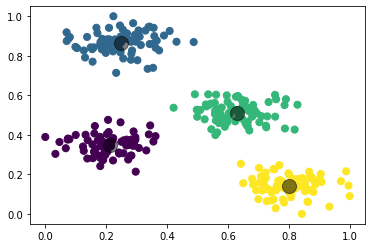

In [3]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.5, random_state=0)

# plt.scatter(X[:, 0], X[:, 1], s=50);
# plt.show()

scaler: MinMaxScaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

kmeans = KMeans(k=4)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)
y_probas = kmeans.predict_proba(X_scaled)
y_score = kmeans.score(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.centroids
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()


# X[:,1] *= 1000

# kmeans = KMeans(k=4)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

# plt.scatter(X[:, 0], X[:, 1], s=50, c=y_kmeans);
# plt.show()
